In [140]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from itertools import product

import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import MultiStepLR

from sklearn.model_selection import train_test_split

In [ ]:
from IPython.display import Audio, display

# Definisci una funzione per riprodurre un suono
def play_sound():
    sound_file = "C:\Windows\Media\Alarm01.wav"  # Sostituisci con il percorso del tuo file audio
    display(Audio(filename=sound_file, autoplay=True))

### Regressore

In [128]:
class RegressorNNVar(nn.Module):
    def __init__(self, hidden_size, activation_function, num_layers, dropout_prob, input_size=10, output_size=3):
        super(RegressorNNVar, self).__init__()
        
        # input layer
        self.layers=[nn.Linear(input_size, hidden_size[0])]
        
        # hidden layers
        i=0
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_size[i], hidden_size[i+1]))
            self.layers.append(activation_function)
            self.layers.append(nn.Dropout(p=dropout_prob)) #disattiva casualmente un'insieme di unità
            i+=1
        
        # output layers
        self.layers.append(nn.Linear(hidden_size[i], output_size))
        
        self.model=nn.Sequential(*self.layers)
    
    def forward(self, x):
        return self.model(x)

### Training model e grid search

In [153]:
'''
def training_model(x_train, y_train, x_test, y_test, proportions, neuron_number, learning_rate, momentum, batch_size,
                   reg_coeff, activation_function, num_layers, dropout, optimizer, num_epochs=1000, plot_curves=False, 
                   return_history=False):
        
    hidden_size =[]
    for j in range(num_layers):
        hidden_size.append(0)
    
    for i in range(len(proportions)):
        hidden_size[i] = int(proportions[i]*neuron_number)  
        
    lr=learning_rate    
    
    #creo l'oggetto regerssore
    model=RegressorNNVar(hidden_size, activation_function, num_layers, dropout)
    
    #definisco la funzione di loss e l'optimizer
    criterion=nn.MSELoss()
    if optimizer == "SGD":
        optimizer = optim.SGD(model.parameters(), learning_rate, momentum, weight_decay=reg_coeff)
    if optimiz == 'Adam':
        optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=reg_coeff)
        
    #preprocessing dataset    
    train_dataset = torch.utils.data.TensorDataset(x_train, y_train) #crea un tensor dataset
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True) #dataloader che suddivide il set di dati in batch più piccoli, per il minibatch
    
    #liste per raggruppare le metriche
    train_losses, test_losses, train_mees, test_mees, train_maes, test_maes, train_mses, test_mses = [], [], [], [], [], [], [], []
    
    #parametri per fermare l'addestramento alla concergenza
    min_mee=float("inf") #min_mee=infinito
    patience_counter, patience = 0, 20
    
    
    #addestramento per ogni epoca
    for epoch in range(num_epochs):
        model.train() #setto il modello per l'addestramento
        i=1
        for inputs, labels in train_dataloader:
            outputs=model(inputs)
            loss=criterion(outputs, labels) #computo la loss
            optimizer.zero_grad() #azzera i gradienti accumulati nelle variabili dei parametri del modello (necessario prima di ogni passaggio di backward)
            loss.backward() #backward pass
            optimizer.step() #update weights
            learning_rate=(1-(i/100))*lr+(i/100)*learning_rate #update learning rate
            i+=
        
            
        model.eval() #setto il modello per l'evaluation
        
        #calcolo la loss
        y_pred=model(x_train)
        train_loss=criterion(y_pred, y_train)
        #calcolo mee, mae e mse
        train_mee, train_mae, train_mse = metrics(y_pred,y_train)
        train_losses.append(train_loss.item())
        train_mees.append(train_mee)
        train_maes.append(train_mae)
        train_mses.append(train_mse)
        
        #evaluation sul validation/test set
        with torch.no_grad():
            test_outputs=model(x_test)
            test_loss=criterion(test_outputs, y_test)
            
            #calcolo mee, mae e mse
            test_mee, test_mae, test_mse = metrics(test_outputs,y_test)
            test_mees.append(test_mee)
            test_maes.append(test_mae)
            test_mses.append(test_mse)
            test_losses.append(test_loss.item())
            
        print(f'Training - Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss.item():.4f}, '
            f'MEE: {train_mee:.4f} | Test - Epoch [{epoch+1}/{num_epochs}], '
            #f'MAE: {train_mae:.4f} | Test - Epoch [{epoch+1}/{num_epochs}], '
            #f'MSE: {train_mse:.4f} | Test - Epoch [{epoch+1}/{num_epochs}], '
            f'Loss: {test_loss.item():.4f} MEE: {test_mee:.4f} ', end='\r')
        
        #controllo la presenza di convergenza
        if train_mee < min_mee and abs(train_mee-min_mee)>1e-3:
            patience_counter=0
            min_mee=train_mee
        else:
            patience_counter +=1
            
        if patience_counter==patience:
            break
        
    print(f'\n N. Epochs = {epoch+1} - Loss (train | test)= ({train_loss.item():.4} | {test_loss.item():.4}) - MEE (train | test) = ({train_mee} | {test_mee}) - MAE (train | test) = ({train_mae} | {test_mae} - MSE (train | test) = ({train_mse} | {test_mse}))')
    
    if plot_curves:
        hyperparams=[hidden_size, learning_rate, momentum, batch_size, reg_coeff, activation_function, num_layers, dropout, num_epochs]
        plot_training_curves(epoch, train_losses, test_losses, train_mees, test_mees, hyperparams)
    
    if return_history:
        return model, epoch+1, np.array(train_losses), np.array(test_losses), np.array(train_mees), np.array(test_mees), np.array(train_mae), np.array(test_mae), np.array(train_mse), np.array(test_mse)
    else:
        return model, epoch+1, train_loss.item(), test_loss.item(), train_mee, test_mee, train_mae, test_mae, train_mse, test_mse
    
 '''

'\ndef training_model(x_train, y_train, x_test, y_test, proportions, neuron_number, learning_rate, momentum, batch_size,\n                   reg_coeff, activation_function, num_layers, dropout, optimizer, num_epochs=1000, plot_curves=False, \n                   return_history=False):\n        \n    hidden_size =[]\n    for j in range(num_layers):\n        hidden_size.append(0)\n    \n    for i in range(len(proportions)):\n        hidden_size[i] = int(proportions[i]*neuron_number)  \n        \n    lr=learning_rate    \n    \n    #creo l\'oggetto regerssore\n    model=RegressorNNVar(hidden_size, activation_function, num_layers, dropout)\n    \n    #definisco la funzione di loss e l\'optimizer\n    criterion=nn.MSELoss()\n    if optimizer == "SGD":\n        optimizer = optim.SGD(model.parameters(), learning_rate, momentum, weight_decay=reg_coeff)\n    if optimiz == \'Adam\':\n        optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=reg_coeff)\n        \n    #preproce

In [159]:

def training_model(x_train, y_train, x_test, y_test, proportions, neuron_number, learning_rate, momentum, batch_size,
                   reg_coeff, activation_function, num_layers, dropout, optimizer, num_epochs=1000, plot_curves=False, 
                   return_history=False):
        
    hidden_size =[]
    for j in range(num_layers):
        hidden_size.append(0)
    
    for i in range(len(proportions)):
        hidden_size[i] = int(proportions[i]*neuron_number)  
        
    #creo l'oggetto regerssore
    model=RegressorNNVar(hidden_size, activation_function, num_layers, dropout)
    
    #definisco la funzione di loss e l'optimizer
    criterion=nn.MSELoss()
    if optimizer == "SGD":
        optimizer = optim.SGD(model.parameters(), learning_rate, momentum, weight_decay=reg_coeff)
    if optimiz == 'Adam':
        optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=reg_coeff)
    #scheduler1 = ExponentialLR(optimizer, gamma=0.9)   
    #scheduler2 = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)
        
    #preprocessing dataset    
    train_dataset = torch.utils.data.TensorDataset(x_train, y_train) #crea un tensor dataset
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True) #dataloader che suddivide il set di dati in batch più piccoli, per il minibatch
    
    #liste per raggruppare le metriche
    train_losses, test_losses, train_mees, test_mees, train_maes, test_maes, train_mses, test_mses = [], [], [], [], [], [], [], []
    
    #parametri per fermare l'addestramento alla concergenza
    min_mee=float("inf") #min_mee=infinito
    patience_counter, patience = 0, 20
    
    
    #addestramento per ogni epoca
    for epoch in range(num_epochs):
        model.train() #setto il modello per l'addestramento
        for inputs, labels in train_dataloader:
            outputs=model(inputs)
            loss=criterion(outputs, labels) #computo la loss
            optimizer.zero_grad() #azzera i gradienti accumulati nelle variabili dei parametri del modello (necessario prima di ogni passaggio di backward)
            loss.backward() #backward pass
            optimizer.step() #update weights
        #scheduler1.step()
        #scheduler2.step()
            
        model.eval() #setto il modello per l'evaluation
        
        #calcolo la loss
        y_pred=model(x_train)
        train_loss=criterion(y_pred, y_train)
        #calcolo mee, mae e mse
        train_mee, train_mae, train_mse = metrics(y_pred,y_train)
        train_losses.append(train_loss.item())
        train_mees.append(train_mee)
        train_maes.append(train_mae)
        train_mses.append(train_mse)
        
        #evaluation sul validation/test set
        with torch.no_grad():
            test_outputs=model(x_test)
            test_loss=criterion(test_outputs, y_test)
            
            #calcolo mee, mae e mse
            test_mee, test_mae, test_mse = metrics(test_outputs,y_test)
            test_mees.append(test_mee)
            test_maes.append(test_mae)
            test_mses.append(test_mse)
            test_losses.append(test_loss.item())
            
        print(f'Training - Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss.item():.4f}, '
            f'MEE: {train_mee:.4f} | Test - Epoch [{epoch+1}/{num_epochs}], '
            #f'MAE: {train_mae:.4f} | Test - Epoch [{epoch+1}/{num_epochs}], '
            #f'MSE: {train_mse:.4f} | Test - Epoch [{epoch+1}/{num_epochs}], '
            f'Loss: {test_loss.item():.4f} MEE: {test_mee:.4f} ', end='\r')
        
        #controllo la presenza di convergenza
        if train_mee < min_mee and abs(train_mee-min_mee)>1e-3:
            patience_counter=0
            min_mee=train_mee
        else:
            patience_counter +=1
            
        if patience_counter==patience:
            break
        
    print(f'\n N. Epochs = {epoch+1} - Loss (train | test)= ({train_loss.item():.4} | {test_loss.item():.4}) - MEE (train | test) = ({train_mee} | {test_mee}) - MAE (train | test) = ({train_mae} | {test_mae} - MSE (train | test) = ({train_mse} | {test_mse}))')
    
    if plot_curves:
        hyperparams=[hidden_size, learning_rate, momentum, batch_size, reg_coeff, activation_function, num_layers, dropout, num_epochs]
        plot_training_curves(epoch, train_losses, test_losses, train_mees, test_mees, hyperparams)
    
    if return_history:
        return model, epoch+1, np.array(train_losses), np.array(test_losses), np.array(train_mees), np.array(test_mees), np.array(train_mae), np.array(test_mae), np.array(train_mse), np.array(test_mse)
    else:
        return model, epoch+1, train_loss.item(), test_loss.item(), train_mee, test_mee, train_mae, test_mae, train_mse, test_mse

In [155]:
def perform_grid_search_kfold(proportionss, neuron_numbers, learning_rates, momentums, batch_sizes, reg_coeffs, 
                              activations, layerss, dropouts, optimiz, k_folds, x, y, plot_curves=False, num_epochs=1000, N=1):
          
        
    best_mee=float('inf') #setto la migliore mee come infinito
    best_hyperparameters=[]

    for proportions, neuron_number, learning_rate, momentum, batch_size, reg_coeff, activation, layers, dropout in product(proportionss, neuron_numbers, learning_rates, momentums, batch_sizes, reg_coeffs, activations, layerss, dropouts):
        print(f'activation={activation}; layers={layers}; proportions={proportions}; neuron_number={neuron_number}; lr={learning_rate}; alpha = {momentum}; batch size = {batch_size}; lambda = {reg_coeff}; optim = {optimiz}')

        kf=KFold(n_splits=k_folds, shuffle=True, random_state=42)

        train_losses, val_losses, train_mees, val_mees, train_maes, val_maes, train_mses, val_mses = [], [], [], [], [], [], [], []

        #perform crossvalidation
        for fold, (train_indices, val_indices) in enumerate(kf.split(x,y)):

            #divido in test e validation
            X_train, X_val = x[train_indices], x[val_indices]
            Y_train, Y_val = y[train_indices], y[val_indices]

             #trainings
            for i in range (0,N):
                _, max_epoch, train_loss, val_loss, train_mee, val_mee, train_mae, val_mae, train_mse, val_mse = training_model(
                X_train, Y_train, X_val, Y_val, proportions, neuron_number, learning_rate, momentum, batch_size, reg_coeff, activation, 
                layers, dropout, optimiz, num_epochs, plot_curves)
                #risultati training
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                train_mees.append(train_mee)
                val_mees.append(val_mee)
                train_maes.append(train_mae)
                val_maes.append(val_mae)
                train_mses.append(train_mse)
                val_mses.append(val_mse)

        print(f'Final Results: activation={activation}; layers={layers}; neuron number={neuron_number}; lr={learning_rate}; alpha = {momentum}; batch size = {batch_size}; lambda = {reg_coeff} --> '
            f'train_loss = {np.mean(train_losses):.4} +- {np.std(train_losses):.4} | '
            f'val_loss = {np.mean(val_losses):.4} +- {np.std(val_losses):.4}'
            f'train_mee = {np.mean(train_mees):.4} +- {np.std(train_mees):.4} | '
            f'val_mee = {np.mean(val_mees):.4} +- {np.std(val_mees):.4}'
            f'train_mae = {np.mean(train_maes):.4} +- {np.std(train_maes):.4} | '
            f'val_mae = {np.mean(val_maes):.4} +- {np.std(val_maes):.4}'
            f'train_mse = {np.mean(train_mses):.4} +- {np.std(train_mses):.4} | '
            f'val_mse = {np.mean(val_mses):.4} +- {np.std(val_mses):.4}')

        if np.mean(val_mees)<best_mee:
            best_mee=np.mean(val_mees)
            best_hyperparams=[proportions, neuron_number, learning_rate, momentum, batch_size, reg_coeff, activation, layers, dropout]  #aggiungere gli altri iperparametri?
            
    print(best_hyperparams)
    return best_hyperparams

In [90]:
def train_with_different_initializations(x_train, y_train, x_test, y_test, proportions, neuron_number, learning_rate, 
                                         momentum, batch_size, reg_coeff, activation, layers, dropout, optimiz, 
                                         max_num_epochs=1000, plot_curves=False, N=5):
   
    train_losses, test_losses, train_mees, test_mees, train_maes, test_maes, train_mses, test_mses = [], [], [], [], [], [], [], []
    
    #trainings
    for i in range (0,N):
        _, epoch, train_loss, test_loss, train_mee, test_mee, train_mae, test_mae, train_mse, test_mse = training_model(x_train,
                        y_train, x_test, y_test, proportions, neuron_number, learning_rate, momentum, batch_size, reg_coeff,
                        activation, layers, dropout, optimiz, max_num_epochs, plot_curves, return_history=True)
        #risultati
        train_losses.append(train_loss)
        train_maes.append(train_mae)
        train_mses.append(train_mse)
        train_mees.append(train_mee)
        test_losses.append(test_loss)
        test_mees.append(test_mee)
        test_maes.append(test_mae)
        test_mses.append(test_mse)


    print(f'Train Loss: {np.mean(train_losses):.4} +- {np.std(train_losses):.4}')
    print(f'Test MEE: {np.mean(test_losses):.4} +- {np.std(test_losses):.4}')
    print(f'Train MEE: {np.mean(train_mees):.4} +- {np.std(train_mees):.4}')
    print(f'Test MEE: {np.mean(test_mees):.4} +- {np.std(test_mees):.4}')
    print(f'Train MAE: {np.mean(train_maes):.4} +- {np.std(train_maes):.4}')
    print(f'Test MAE: {np.mean(test_maes):.4} +- {np.std(test_maes):.4}')
    print(f'Train MSE: {np.mean(train_mses):.4} +- {np.std(train_mses):.4}')
    print(f'Test MSE: {np.mean(test_mses):.4} +- {np.std(test_mses):.4}')


### Funzioni ausiliarie

In [72]:
def plot_training_curves(epoch, train_losses, test_losses, train_mees, test_mees, hyperparams):
    
    plt.figure(figsize=(12, 8))
    plt.suptitle(f'Batch Size={hyperparams[3]},Activation Function={hyperparams[5]}, Layers={hyperparams[6]} Hidden Units={hyperparams[0]}, Eta={hyperparams[1]}, Alpha={hyperparams[2]}, Lambda={hyperparams[4]}')
    # Loss plots
    plt.subplot(2, 2, 1)
    plt.plot(range(1, epoch + 2), train_losses, label='Training Loss', color = 'red')
    plt.plot(range(1, epoch + 2), test_losses, label='Test Loss', color = 'blue', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # MEE plots
    plt.subplot(2, 2, 2)
    plt.plot(range(1, epoch + 2), train_mees, label='Training MEE', color='red')
    plt.plot(range(1, epoch + 2), test_mees, label='Test MEE', color = 'blue', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('MEE')
    plt.legend()

    # Loss plots
    plt.subplot(2, 2, 3)
    plt.plot(range(1, epoch + 2), train_losses, label='Training Loss', color = 'red')
    plt.plot(range(1, epoch + 2), test_losses, label='Test Loss', color = 'blue', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim(0,10)
    plt.legend()

    # MEE plots
    plt.subplot(2, 2, 4)
    plt.plot(range(1, epoch + 2), train_mees, label='Training MEE', color='red')
    plt.plot(range(1, epoch + 2), test_mees, label='Test MEE', color = 'blue', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('MEE')
    plt.ylim(0,10)
    plt.legend()

    plt.tight_layout()

    plt.show()

In [73]:
#questa devo ancora rivederla

def plot_mean_std(N,train_hist, test_hist,label):
    
    mean_tr = np.array(train_hist).mean(axis=0)
    std_tr = np.array(train_hist).std(axis=0)
    mean_te = np.array(test_hist).mean(axis=0)
    std_te = np.array(test_hist).std(axis=0)

    plt.figure(figsize=(9, 8))
    plt.subplot(2,1,1)
    plt.plot(mean_tr, label=f'Training {label} (mean $\pm$ std)', color = 'red', linewidth=1)
    plt.fill_between(range(0,len(train_hist[0])),mean_tr-std_tr, mean_tr+std_tr, color='crimson', alpha=0.3)

    plt.plot(mean_te, label=f'Test {label} (mean $\pm$ std)', color = 'blue', linestyle='--', linewidth=1)
    plt.fill_between(range(0,len(test_hist[0])),mean_te-std_te, mean_te+std_te, color='blue', alpha=0.3)

    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.legend()

    plt.subplot(2,1,2)

    plt.plot(mean_tr, label=f'Training {label} (mean $\pm$ std)', color = 'red', linewidth=1)
    plt.fill_between(range(0,len(train_hist[0])),mean_tr-std_tr, mean_tr+std_tr, color='crimson', alpha=0.3)

    plt.plot(mean_te, label=f'Test {label} (mean $\pm$ std)', color = 'blue', linestyle='--', linewidth=1)
    plt.fill_between(range(0,len(test_hist[0])),mean_te-std_te, mean_te+std_te, color='blue', alpha=0.3)

    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.ylim(0,1)
    plt.legend()
    plt.show()


In [74]:
def metrics(y_pred, y_true):
    
    # Check if the tensors have the correct shape
    if y_pred.shape[1] != 3 or y_true.shape[1] != 3 or y_pred.shape[0] != y_true.shape[0]:
        raise ValueError("Input tensors must be of size (N, 3)")


    # Compute Euclidean distance
    euclidean_distance = torch.norm(y_pred - y_true, dim=1)

    # Calculate the mean Euclidean error
    mean_error = torch.mean(euclidean_distance)
    
    
    # Calcolo della Mean Absolute Error (MAE)
    mae = F.l1_loss(y_pred, y_true)

    # Calcolo della Mean Squared Error (MSE)
    mse = F.mse_loss(y_pred, y_true)


    return mean_error.item(), mae.item(), mse.item()

In [75]:
def reshape_history(N, hist):
    min_len=float("inf")
    for i in range(0,N):
        if len(hist[i])<min_len:
            min_len=len(hist[i])
            
    for i in range(0,N):
        hist[i]=hist[i][:min_len]
    
    return hist

### Preprocessing dataset

In [76]:
dataset = np.loadtxt('ML-CUP23-TR.csv', delimiter=',')
X = dataset[:,1:11]
y = dataset[:,11:14]

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)



# Split the data into training and testing sets (80%/20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Modello tentativi

In [160]:
proportionss = [[0.28, 0.5, 0.22], [1/3, 1/3, 1/3]]
hidden_neurons = [1000] #total number of neurons
learning_rates = [1e-04]
momentums = [0] #if optimiz = 'Adam' it doesn't matter # Non importa che ci sia o che valore ci metti?
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
optimiz = 'Adam' #either 'SGD' or 'Adam'


best_hp = perform_grid_search_kfold(proportionss,
                                    hidden_neurons,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    activations,
                                    layerss,
                                    dropouts,
                                    optimiz,
                                    k_folds=3,
                                    x=X_train,
                                    y=y_train,
                                    num_epochs=5000,
                                    plot_curves=False,
                                    N=10)

activation=Tanh(); layers=3; proportions=[0.28, 0.5, 0.22]; neuron_number=1000; lr=0.0001; alpha = 0; batch size = 128; lambda = 0.001; optim = Adam
Training - Epoch [1807/5000], Loss: 0.1376, MEE: 0.3698 | Test - Epoch [1807/5000], Loss: 0.3712 MEE: 0.6864     
 N. Epochs = 1807 - Loss (train | test)= (0.1376 | 0.3712) - MEE (train | test) = (0.3697943687438965 | 0.6864099502563477) - MAE (train | test) = (0.18897557258605957 | 0.3433482348918915 - MSE (train | test) = (0.13761883974075317 | 0.37117817997932434))
Training - Epoch [1911/5000], Loss: 0.1627, MEE: 0.3741 | Test - Epoch [1911/5000], Loss: 0.3546 MEE: 0.6509     
 N. Epochs = 1911 - Loss (train | test)= (0.1627 | 0.3546) - MEE (train | test) = (0.3741230070590973 | 0.6508898138999939) - MAE (train | test) = (0.19036784768104553 | 0.33010387420654297 - MSE (train | test) = (0.16268092393875122 | 0.3546471893787384))
Training - Epoch [1777/5000], Loss: 0.2092, MEE: 0.4325 | Test - Epoch [1777/5000], Loss: 0.3421 MEE: 0.6673 

Training - Epoch [1710/5000], Loss: 0.2303, MEE: 0.3935 | Test - Epoch [1710/5000], Loss: 0.7991 MEE: 1.0235     
 N. Epochs = 1710 - Loss (train | test)= (0.2303 | 0.7991) - MEE (train | test) = (0.3935135304927826 | 1.0235427618026733) - MAE (train | test) = (0.19949397444725037 | 0.5173691511154175 - MSE (train | test) = (0.2302849441766739 | 0.7991014719009399))
Training - Epoch [1917/5000], Loss: 0.1254, MEE: 0.3107 | Test - Epoch [1917/5000], Loss: 0.6186 MEE: 0.8985     
 N. Epochs = 1917 - Loss (train | test)= (0.1254 | 0.6186) - MEE (train | test) = (0.3107253611087799 | 0.898535966873169) - MAE (train | test) = (0.1579728126525879 | 0.45168784260749817 - MSE (train | test) = (0.12540222704410553 | 0.6185837984085083))
Training - Epoch [1890/5000], Loss: 0.1731, MEE: 0.3248 | Test - Epoch [1890/5000], Loss: 0.6123 MEE: 0.8816     
 N. Epochs = 1890 - Loss (train | test)= (0.1731 | 0.6123) - MEE (train | test) = (0.3248247504234314 | 0.8815789222717285) - MAE (train | test) = (

Training - Epoch [1636/5000], Loss: 0.0867, MEE: 0.3278 | Test - Epoch [1636/5000], Loss: 0.5989 MEE: 0.8233     
 N. Epochs = 1636 - Loss (train | test)= (0.08668 | 0.5989) - MEE (train | test) = (0.32780298590660095 | 0.823345959186554) - MAE (train | test) = (0.16599184274673462 | 0.4077235162258148 - MSE (train | test) = (0.08668298274278641 | 0.5989059209823608))
Training - Epoch [1774/5000], Loss: 0.0565, MEE: 0.3125 | Test - Epoch [1774/5000], Loss: 0.4796 MEE: 0.7835     
 N. Epochs = 1774 - Loss (train | test)= (0.05655 | 0.4796) - MEE (train | test) = (0.31245577335357666 | 0.7834922671318054) - MAE (train | test) = (0.15706780552864075 | 0.38532525300979614 - MSE (train | test) = (0.056547340005636215 | 0.47959449887275696))
Training - Epoch [1711/5000], Loss: 0.0611, MEE: 0.3095 | Test - Epoch [1711/5000], Loss: 0.5886 MEE: 0.8349     
 N. Epochs = 1711 - Loss (train | test)= (0.06112 | 0.5886) - MEE (train | test) = (0.3094547390937805 | 0.834941029548645) - MAE (train | t

Training - Epoch [1251/5000], Loss: 0.0568, MEE: 0.3108 | Test - Epoch [1251/5000], Loss: 0.4274 MEE: 0.6432 1   
 N. Epochs = 1251 - Loss (train | test)= (0.05681 | 0.4274) - MEE (train | test) = (0.3108065724372864 | 0.6432040333747864) - MAE (train | test) = (0.15722429752349854 | 0.3277941048145294 - MSE (train | test) = (0.056807491928339005 | 0.4273824989795685))


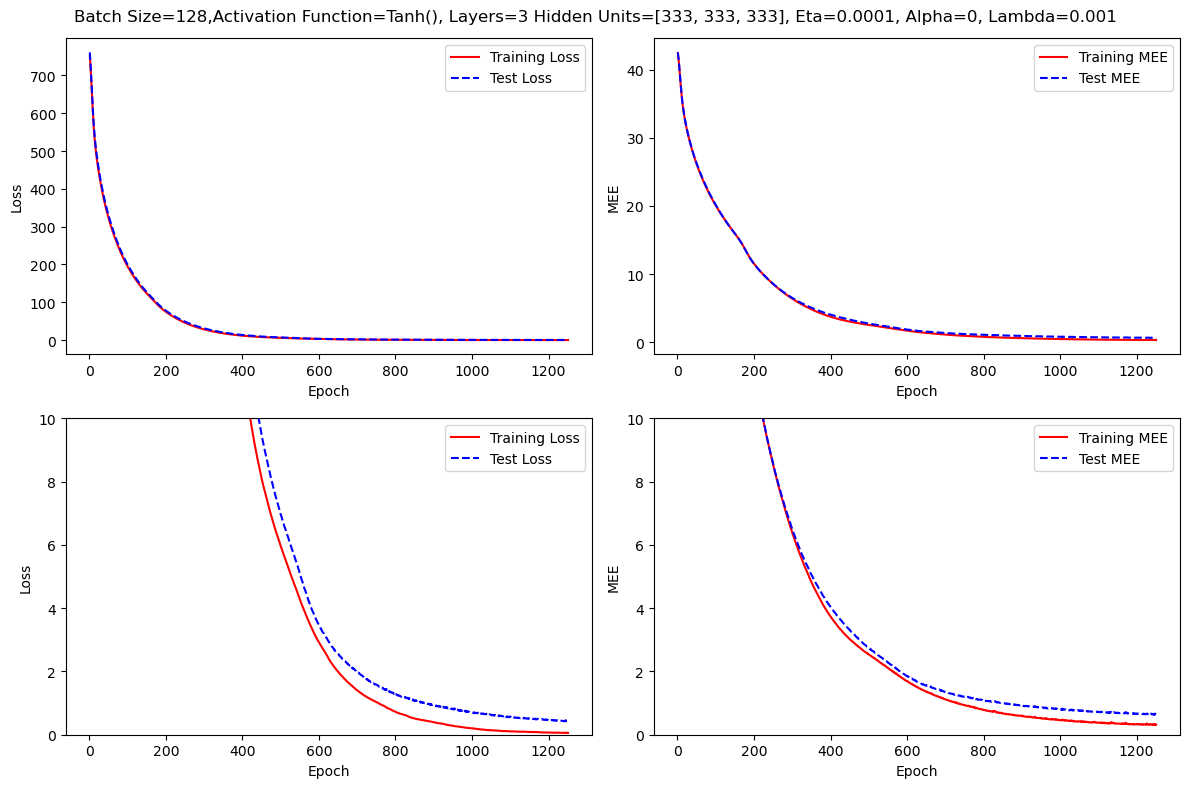

(RegressorNNVar(
   (model): Sequential(
     (0): Linear(in_features=10, out_features=333, bias=True)
     (1): Linear(in_features=333, out_features=333, bias=True)
     (2): Tanh()
     (3): Dropout(p=0, inplace=False)
     (4): Linear(in_features=333, out_features=333, bias=True)
     (5): Tanh()
     (6): Dropout(p=0, inplace=False)
     (7): Linear(in_features=333, out_features=3, bias=True)
   )
 ),
 1251,
 0.056807491928339005,
 0.4273824989795685,
 0.3108065724372864,
 0.6432040333747864,
 0.15722429752349854,
 0.3277941048145294,
 0.056807491928339005,
 0.4273824989795685)

In [162]:
# train the model on all the train set using the best hyperparameters found


training_model(x_train=X_train,
               y_train=y_train,
               x_test=X_test,
               y_test=y_test,
               proportions = best_hp[0],
               neuron_number=best_hp[1],
               learning_rate=best_hp[2],
               momentum=best_hp[3],
               batch_size = best_hp[4],
               reg_coeff= best_hp[5],
               activation_function = best_hp[6],
               num_layers= best_hp[7],
               dropout = best_hp[8],
               optimizer="Adam",
               num_epochs=5000,
               plot_curves=True)

In [163]:
train_with_different_initializations(x_train=X_train,
               y_train=y_train,
               x_test=X_test,
               y_test=y_test,
               proportions=best_hp[0],
               neuron_number=best_hp[1],
               learning_rate=best_hp[2],
               momentum=best_hp[3],
               batch_size = best_hp[4],
               reg_coeff= best_hp[5],
               activation= best_hp[6],
               layers= best_hp[7],
               dropout= best_hp[8],
               optimiz=optimiz,
               max_num_epochs=5000,
               plot_curves=False,
               N=5)

Training - Epoch [1243/5000], Loss: 0.0650, MEE: 0.3145 | Test - Epoch [1243/5000], Loss: 0.4991 MEE: 0.6952 3   
 N. Epochs = 1243 - Loss (train | test)= (0.06503 | 0.4991) - MEE (train | test) = (0.31445804238319397 | 0.6951809525489807) - MAE (train | test) = (0.15877944231033325 | 0.3527967035770416 - MSE (train | test) = (0.0650317445397377 | 0.4991239011287689))
Training - Epoch [1217/5000], Loss: 0.0872, MEE: 0.3453 | Test - Epoch [1217/5000], Loss: 0.5026 MEE: 0.6925 1   
 N. Epochs = 1217 - Loss (train | test)= (0.08715 | 0.5026) - MEE (train | test) = (0.3452814519405365 | 0.692524790763855) - MAE (train | test) = (0.1745842546224594 | 0.34904584288597107 - MSE (train | test) = (0.08715097606182098 | 0.5025535821914673))
Training - Epoch [1276/5000], Loss: 0.0743, MEE: 0.3213 | Test - Epoch [1276/5000], Loss: 0.5070 MEE: 0.6834     
 N. Epochs = 1276 - Loss (train | test)= (0.07431 | 0.507) - MEE (train | test) = (0.32132554054260254 | 0.6834375262260437) - MAE (train | test)

ValueError: operands could not be broadcast together with shapes (1243,) (1217,) 

In [ ]:
play_sound()

In [ ]:
#save models to file
#for index, model in enumerate(models):
    #torch.save(model,f'saved_models/trained_nn{index}.pth')

### Commitee

In [ ]:
#da vedere

In [ ]:
'''
def committee(model_name, N):
    model0 = torch.load(f'saved_models/{model_name}0.pth')
    model0.eval()
    output_sum = model0(X_test)
    #print(output_sum[0])

    for i in range(1,N):
        model = torch.load(f'saved_models/{model_name}{i}.pth')
        model.eval()
        test_outputs = model(X_test)
        #print(test_outputs[0])
        output_sum += test_outputs
        #print(output_sum[0])

    return output_sum/N


output_commitee = committee('trained_nn', N=5)
print(output_commitee.shape)
# Calculate test mee
test_mee = mean_euclidean_error(output_commitee,y_test)
print(test_mee)

'''